In [2]:
import matplotlib_themes
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import matmul
from morknn.net import Net
from morknn.activators import Activator
from morknn.layers import Layer
# import networkx as nx     # TODO: make a visualization class

%config InlineBackend.figure_formats = ['svg']

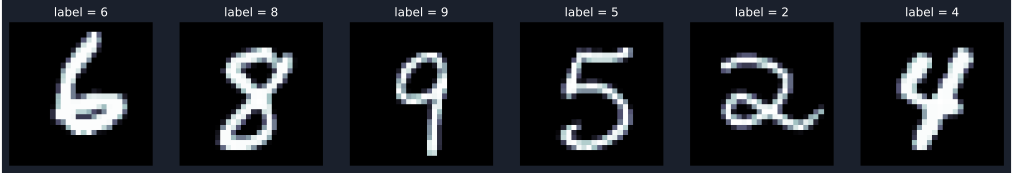

In [9]:
# TODO: create a library for visualizations

def mnist_dataset(split_factor=0.05):
    scale = 1 / 255
    data_df = pd.read_csv(f'./datasets/mnist/train.csv')
    data_x = data_df[data_df.columns[1:]].to_numpy() * scale
    data_y = data_df['label'].to_numpy()
    data_x = data_x.astype(np.float32)
    data_y = data_y.astype(np.int32)
    split_index = int(data_y.shape[0] * split_factor)
    train_x = data_x[split_index:, :]
    test_x = data_x[:split_index, :]
    train_y = data_y[split_index:]
    test_y = data_y[:split_index]
    return train_x.transpose(), train_y, test_x.transpose(), test_y

def plot_data(data_x, data_y, nplots=6):
    data_x = data_x.transpose()
    nplots = np.maximum(nplots, 6)
    random_index = int(np.random.uniform(nplots, train_x.shape[0]) - nplots)
    images = data_x[random_index:random_index + nplots]
    labels = data_y[random_index:random_index + nplots]
    fig, axes = plt.subplots(1, nplots, figsize=(2.4 * nplots, 2.4), sharex=True, sharey=True)
    for image, label, ax in zip(images, labels, axes):
        image = image.reshape(28, 28)
        ax.set_title(f'label = {label:.0f}')
        ax.imshow(image, cmap='bone')
        ax.axis('off')
    plt.tight_layout()

train_x, train_y, test_x, test_y = mnist_dataset()
plot_data(train_x, train_y)

## Example numpy matmul

```python
[1] a = np.random.rand(2, 3).astype(np.float32)
    b = np.random.rand(3, 5).astype(np.float32)
    c = a@b
    print(c)
```
```text 
[1] array(
        [[0.4549801 , 0.6522088 , 1.0393813 , 0.67228025, 0.32949623],
        [0.65349907, 1.0044786 , 1.6312988 , 0.90355206, 0.581241  ]],
        dtype=float32
    )
```
```python
[2] print(a.shape)
    print(b.shape)
    print(c.shape)
```
```text
[2] a.shape = (2, 3)
    b.shape =    (3, 5)
    c.shape = (2,    5)
```

In [12]:
print(f'train_x shape = {train_x.shape}')
print(f'train_y shape = {train_y.shape}')
print(f' test_x shape = {test_x.shape}')
print(f' test_x shape = {test_y.shape}')

train_x shape = (784, 39900)
train_y shape = (39900,)
 test_x shape = (784, 2100)
 test_x shape = (2100,)


In [4]:
class Net2:
    def __init__(self, input_dims=None, output_dims=None, activations=None, dtypes=None, names=None):
        if input_dims and output_dims and activations:
            n_layers = len(input_dims)
            names = names if names else np.arange(n_layers)
            dtypes = dtypes if dtypes else [np.float32] * n_layers
            zipper = zip(input_dims, output_dims, activations, dtypes, names)
            self.layers = [
                Layer(
                    input_dim=i_d, output_dim=o_d, activation=act, dtype=dtype, name=name
                ) for i_d, o_d, act, dtype, name in zipper
            ]
        else:
            self.layers = None
        
    def define(self, layers):
        self.layers = layers
        
    def describe(self):
        "same as print"
        print(self)
        
    def __repr__(self):
        try:
            name = [str(layer) for layer in self.layers]
            return '\n'.join(name)
        except TypeError as e:
            if self.layers:
                name = [str(layer) for layer in self.layers]
                return str('\n'.join(name))
            else:
                return f'<Net: 0 layers>'
        
    def one_hot(self, data_y):
        n_labels = data_y.shape[0]
        n_options = int(data_y.max())
        one_hoty = np.zeros((n_labels, n_options + 1))
        one_hoty[np.arange(n_labels), data_y] = 1
        return one_hoty.transpose()

    def _forward_prop(self, data_x):
        assert self.layers is not None
        for layer in self.layers:
            print(layer.weights.shape, data_x.shape)
            data_z = matmul(layer.weights, data_x) + layer.bias
            data_x = layer.activation._act()(data_z)
        return data_z, data_x

    def _backward_prop(self, data_x, data_y, data_z):
        assert self.layers is not None
        for n, layer in enumerate(reversed(self.layers)):
            
            if n == 0:
                d_z = data_z - data_y
                print(f'{n}: d_z={d_z.shape}, data_x.T={data_x.transpose().shape}')
                delta_weights = self.normalize_factor * matmul(d_z, data_x.transpose())
            else:
                d_z = matmul(self.layers[::-1][n-1].weights.transpose(), d_z) * layer.activation._d_act()(data_z)
                
                print(f'{n}: d_z={d_z.shape}, data_x.T={data_x.transpose().shape}')
                delta_weights = self.normalize_factor * matmul(d_z, data_x.transpose())
            
            delta_bias = self.normalize_factor * np.sum(delta_weights)
            
            print(f'{n}: weights={layer.weights.shape}, d_weights={delta_weights.shape}')
            layer.weights = layer.weights - self.learning_rate * delta_weights
            layer.bias = layer.bias - self.learning_rate * delta_bias
    
    def train(self, data_x, data_y, learning_rate, epochs, verbose=True):
        self.normalize_factor = 1 / data_x.shape[0]
        self.learning_rate = learning_rate
        data_y = self.one_hot(data_y)
        for epoch in range(epochs):
            data_z, data_x = self._forward_prop(data_x)
            self._backward_prop(data_x, data_y, data_z)
            if epoch % 10 == 0:
                pred = self.get_predictions(data_x)
                accuracy = self.get_accuracy(pred, data_y)
                print(f"EPOCH: {epoch:03d}, accuracy: {accuracy:.4f}")
    
    def validate(self, val_x, val_y, verbose=True):
        pass
    
    def get_predictions(self, A):
        pred = np.argmax(A, 0)
        return pred

    def get_accuracy(self, predictions, data_y):
        accuracy = np.sum(predictions == data_y) / data_y.shape[0]
        return accuracy

In [8]:
output_dims = [40, 30, 20, 10]
input_dims = [train_x.shape[0], *output_dims[:-1]]
activations = ['relu', 'relu', 'relu', 'softmax']
names = ['input', 'hidden_1', 'hidden_2', 'output']

net = Net2(output_dims, input_dims, activations, names=names)
# net.train(train_x, train_y, learning_rate=0.01, epochs=100, verbose=True)

In [28]:
dat_x = train_x.copy()

# dat_x = net.layers[0].activation._act()(matmul(net.layers[0].weights, dat_x) + net.layers[0].bias)
# dat_x = net.layers[1].activation._act()(matmul(net.layers[1].weights, dat_x) + net.layers[1].bias)
# dat_x = net.layers[2].activation._act()(matmul(net.layers[2].weights, dat_x) + net.layers[2].bias)
# dat_x = net.layers[3].activation._act()(matmul(net.layers[3].weights, dat_x) + net.layers[3].bias)

for layer in net.layers:
    dat_x = layer.activation._act()(matmul(layer.weights, dat_x) + layer.bias)
    print(f'{layer}' + f'output: {dat_x.shape}\n')

LAYER:
 -        name: 'input'
 - weights_dim: (40, 784)
 -    bias_dim: (40, 1)
 -       dtype: <class 'numpy.float32'>
 -  activation: <Activation: 'relu'>
        output: (40, 39900)

LAYER:
 -        name: 'hidden_1'
 - weights_dim: (30, 40)
 -    bias_dim: (30, 1)
 -       dtype: <class 'numpy.float32'>
 -  activation: <Activation: 'relu'>
        output: (30, 39900)

LAYER:
 -        name: 'hidden_2'
 - weights_dim: (20, 30)
 -    bias_dim: (20, 1)
 -       dtype: <class 'numpy.float32'>
 -  activation: <Activation: 'relu'>
        output: (20, 39900)

LAYER:
 -        name: 'output'
 - weights_dim: (10, 20)
 -    bias_dim: (10, 1)
 -       dtype: <class 'numpy.float32'>
 -  activation: <Activation: 'softmax'>
        output: (10, 39900)



In [7]:
# net = Net2()
# layers = [
#     Layer(784, 10, 'relu', dtype=np.float32, name='input'),
#     Layer(10, 10, 'relu', dtype=np.float32, name='hidden_1'),
#     Layer(20, 20, 'relu', dtype=np.float32, name='hidden_2'),
#     Layer(10, 10, 'softmax', dtype=np.float32, name='output'),
# ]
# net.define(layers=layers)
# print(net)
# print(net.layers)
# print(net.rev_layers)

In [8]:
# chatGPT response
class Trainer:
    def __init__(self, net):
        self.weights = net[0]
        self.biases = net[1]
        self.acts = net[2]
        self.DTYPE = np.float32
        
    def one_hot(data_y):
        n_labels = data_y.shape[0]
        n_options = int(data_y.max())
        one_hoty = np.zeros((n_labels, n_options + 1))
        one_hoty[np.arange(n_labels), data_y] = 1
        one_hoty = one_hoty.transpose()
        return one_hoty

    def feedforward(self, x):
        for w, b, a in zip(self.weights, self.biases, self.activations):
            x = a(matmul(w, x) + b)
        return x

    def backpropagation(self, x, y):
        delta_w = [np.zeros(w.shape).astye(self.DTYPE) for w in self.weights]
        delta_b = [np.zeros(b.shape).astye(self.DTYPE) for b in self.biases]
        
        # feedforward
        activation = x
        activations = [x]
        zs = []
        for w, b, a in zip(self.weights, self.biases, self.acts):
            z = np.dot(w, activation) + b
            zs.append(z)
            activations.append(a[0](z))

        # backward pass
        y = self.one_hot(y)
        delta = (activations[-1] - y) * self.acts[-1][-1](zs[-1])
        delta_b[-1] = delta
        delta_w[-1] = np.dot(delta, activations[-2].transpose())
        
        for l in range(2, len(self.layers)):
            z = zs[-l]
            sp = self.acts[-l][-1](z)
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
            delta_b[-l] = delta
            delta_w[-l] = np.dot(delta, activations[-l - 1].transpose())
        return (delta_w, delta_b)

    def update_parameters(self, mini_batch, lr):
        delta_w = [np.zeros(w.shape).astype(np.float32) for w in self.weights]
        delta_b = [np.zeros(b.shape).astype(np.float32) for b in self.biases]
        for x, y in mini_batch:
            delta_delta_w, delta_delta_b = self.backpropagation(x, y)
            delta_w = [nw + dnw for nw, dnw in zip(delta_w, delta_delta_w)]
            delta_b = [nb + dnb for nb, dnb in zip(delta_b, delta_delta_b)]
        self.weights = [w - lr / len(mini_batch) * nw for w, nw in zip(self.weights, delta_w)]
        self.biases = [b - lr / len(mini_batch) * nb for b, nb in zip(self.biases, delta_b)]

    def train(self, epochs=5, mini_batch_size=10, lr=0.01):
        for epoch in range(epochs):
            # np.random.shuffle(training_data)
            mini_batches = [training_data[k:k + mini_batch_size] for k in range(0, len(training_data), mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_parameters(mini_batch, lr)
            print(f'Epoch {epoch} complete')